In [1]:

import numpy as np
import matplotlib.pyplot as plt
import math
import ipympl
from timeit import default_timer as timer

In [2]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import openbabel as ob
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import nglview as nv
import mplcursors

In [3]:
from load_data import load_file
from helper_functions import calc_scaling,single_rotD,single_rotP,rotate_molecule
from calc_average import full_average,full_average_IR,full_average_R,full_average_R_orth,numerical_sector_average
from calc_single import oriented_IR,oriented_R,single_rot_IR,single_rot_R

In [4]:
from plotting_functions import create_average_spec_single

Loaded  freq-19813-90-2.fchk
SMILES:  [Au]Sc1[cH][cH]c([cH][cH]1)c1[cH][cH][cH][cH][cH]1


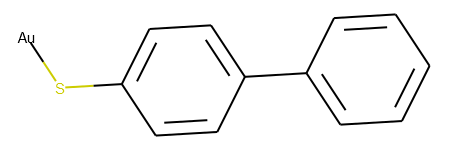

In [5]:
outfilename="freq-19813-90-2.out"   # less accurate
filename="freq-19813-90-2.fchk"   # more accurate
fr,Z,Q,D,P,nat,aniso=load_file(filename)

obConversion = ob.OBConversion()
obConversion.SetInAndOutFormats("out", "can") 
obConversion.SetOptions(str("h"), ob.OBConversion.OUTOPTIONS)
mol0 = ob.OBMol()
obConversion.ReadFile(mol0, outfilename)

outMDL = obConversion.WriteString(mol0)
spl=outMDL.split("\t")
smiles = spl[0]
if len(smiles)<2:
        print("error in smiles generation")
        smiles=filename
print("SMILES: ",smiles)

mol=Chem.MolFromSmiles(smiles)
display(mol)

#obConversion.SetOutFormat("mol") 
#sdfmol = obConversion.WriteString(mol0)


In [6]:

def rotate_view(view, phi=0, theta=0, xi=0, degrees=True):
    radians = 1
    if degrees: radians = math.pi / 180
    view.control.spin([0, 0, 1], phi*radians)
    view.control.spin([1, 0, 0], theta*radians)
    view.control.spin([0, 0, 1], xi*radians)
    


In [7]:
np.shape(P)

(63, 3, 3)

In [8]:
 from nglview.viewer_control import ViewerControl




In [9]:
phys_params=dict(laser =785, #633, 
                 T = 298.15
                 )

# calculate intensity scaling factors
v0= math.pow(10, 7)/phys_params['laser']

scalingIR,scaling,scalingexp,scalingpolar= calc_scaling(phys_params['T'])
pi=math.pi
torad=pi/180

In [10]:
def plot_spectrum_oriented(phi,theta,show_av,broadening,gammaIR,gammaR):
    # modes: list of normal modes to calculate
    modes=range(0,len(fr)) 

    rotate=0    # rotate molecule to reference orientation before analysis, NOT IMPLEMENTED YET
    numerical=0 # perform numerical tests
    single=1    # get intensities for single rotations

    th=theta*torad  
    ph=phi*torad 

    Lm=1
    
#    rotfile=rotate_to_reference(mol0,outfilename,savexyz=1,calcvol=False)
    view = nv.NGLWidget()
 #   comp = view.add_component(rotfile)
 #   torad=np.pi/180
 #   phi=0*torad
 #   theta=30*torad

    #rotate_view(view, phi=0, theta=0, xi=0, degrees=True)
    
    #print(orientationMatrix = view.ViewerControl)

 #   display(view)

    
    
    Drot,Prot,rotfile2,cell=rotate_molecule(mol0,outfilename,D,P,phi=ph,theta=th)
    print("Molecular cell dimensions: ({:.2f},{:.2f},{:.2f}) ".format(cell[0],cell[1],cell[2])+u'\u212B')
    print("Gap size: {:.2f} ".format(cell[2])+u'\u212B')
    print("Occupied surface area: {:.2f} ".format(cell[0]*cell[1])+u'\u212B\u00B2')

  #  view.remove_component(comp)
    comp = view.add_component(rotfile2)

    #view.shape.add_arrow([-cell[0]/2,0,0], [cell[0]/2,0,0], [ 0, 0, 0 ], 0.3, 'cx')
    #view.shape.add_arrow([0,-cell[1],0], [0,0,0], [ 0, 0, 0 ], 0.3, 'cy')

    #c2.set_rotation([theta,0,phi])
    #c2.set_position([0,0,0])
    #view.add_axes()
    #view.add_representation(repr_type='axes',  showBox=1, showAxes=1)    
    
    control = ViewerControl(view=view)
    control.spin([1,0,0],-90*torad)
    control.spin([0,0,1],40*torad)
    view.shape.add_arrow([0,0,0], [8,0,0], [ 0, 0, 1 ], 0.2, 'x')
    view.shape.add_arrow([0,0,0], [0,8,0], [ 1, 0, 0 ], 0.2, 'y')
    view.shape.add_arrow([0,0,0], [0,0,8], [ 0, 0.8, 0.2 ], 0.2, 'z')
    view.shape.add('text', [7, 0, 0.5], [ 0, 0, 1 ], 3, 'x')
    view.shape.add('text', [0, 7, 0.5], [ 1, 0, 0 ], 3, 'y')
    view.shape.add('text', [0, 0.5, 7], [ 0, 0.8, 0.2 ], 3, 'z')
    display(view)


    # Full orientation averages
    nummodes=len(modes)
    conv_av=np.zeros((nummodes))     # conversion intensity
    ir_av=np.zeros((nummodes))    # IR intensity
    r_av=np.zeros((nummodes))     # Raman Stokes intensity, parallel fields
    r_a_av=np.zeros((nummodes))   # Raman anti-Stokes intensity, parallel fields
    r_av_ort=np.zeros((nummodes)) # Raman Stokes intensity, orthogonal fields

    # Single orientations
    ir_single=np.zeros((nummodes))  # IR intensity
    r_single=np.zeros((nummodes))   # Raman Stokes, parallel fields
    conv_single=np.zeros((nummodes)) # Conversion intensity, parallel fields

    for n,m in enumerate(modes):
  #      P=symmetrize(P0[m,:,:])
  #      if rotate:
  #          Drot,Prot,R=rotate_to_reference(D[m,:],P,Z,Q)

    # Calculate frequency-dependent scaling factors
        # Usual Stokes for thermal population
        scalingR=Lm*scaling* math.pow(v0 - fr[m], 4) / (
                    fr[m] * (1 - math.exp(scalingexp * fr[m]))) 
        # Usual anti-Stokes for thermal population
        scalingaR=Lm*scaling* math.pow(v0 + fr[m], 4) / fr[m] *(
               1/(-1+math.exp(-scalingexp * fr[m]))) # 
        # For THOR: anti-Stokes without population
        scalingTHOR=Lm*scaling* math.pow(v0 + fr[m], 4) / fr[m] 

    # Calculate full averages analytically
        starta=timer()
        conv_av[n] = scalingIR *scalingTHOR*full_average(Drot[m],Prot[m])  
        ir_av[n]=scalingIR*full_average_IR(Drot[m]) 
        Rav=full_average_R(Prot[m])
        r_av[n]=scalingR*Rav 
        enda=timer()
        r_a_av[n]=scalingaR*Rav 
        r_ort,depol=full_average_R_orth(Prot[m])
        r_av_ort[n]=scalingR*r_ort 

    # Test: Calculate full averages numerically 
        if numerical:
                startm=timer()
                ir_numav, r_numav,p_numav=numerical_sector_average(Drot[m],Prot[m],1,1,0,0,0)
                ir_numav=scalingIR*ir_numav
                r_numav=scalingR*r_numav
                p_numav=scalingIR *scalingTHOR*p_numav
                endm=timer()
                print("Time for evaluation\n   Analytic \t{:.1e}s \n   Numerical \t{:.1e}s \n   Num/An \t{:.1e}".format(
                    enda-starta,endm-startm,(endm-startm)/(enda-starta)))
                print("Abs. and rel. error of numerical results\n   IR \t\t{:.2e}\t{:.2f}% \n   Raman \t{:.2e}\t{:.2f}% \n   Conv \t{:.2e}\t{:.2f}%".format(
                    ir_numav-ir_av[n],(ir_numav-ir_av[n])/ir_av[n]*100,r_numav-r_av[n],(r_numav-r_av[n])/r_av[n]*100,
                    p_numav-conv_av[n],(p_numav-conv_av[n])/conv_av[n]*100))
                print("-----------------------------------------------")

    # Calculate single orientations analytically
        if single:
                if numerical:
                    print("IR intensity                            | Raman intensity")
                    print("single    numeric1  numeric2   orient   | single    numeric1   numeric2   orient")
                ir=single_rot_IR(Drot[m],a=ph,b=th,c=0) 
                r=single_rot_R(Prot[m],a=ph,b=th,c=0)
                ir_single[n]=scalingIR*ir
                r_single[n]=scalingR*r
                conv_single[n]=scalingIR*scalingTHOR*ir*r

    # Tests: numerical average on rotated D and P should give the same value 
    #             when using nump=1, 
    #             or in the limit of k->inf and l->inf
    #        rotating D and P first and using field oriented along z should also give the same
                if numerical:
                            Drot2=single_rotD(Drot[m],a=ph,b=th,c=0)
                            Prot2=single_rotP(Prot[m],a=ph,b=th,c=0)
                            ir_snumav, r_snumav,p_snumav=numerical_sector_average(Drot2,Prot2,1,1,0,0,0,nump=1)
                            ir_snumav2, r_snumav2,p_snumav2=numerical_sector_average(Drot2,Prot2,1000000,1000000,0,0,0,nump=30)
                            print("{:.3e} {:.3e} {:.3e} {:.3e} | {:.3e} {:.3e} {:.3e} {:.3e}".format(ir_single[n],
                                scalingIR*ir_snumav,scalingIR*ir_snumav2,scalingIR*oriented_IR(Drot2),
                                r_single[n],
                                scalingR*r_snumav,scalingR*r_snumav2,scalingR*oriented_R(Prot2)))

    
    xmin=30
    xmax=1000
    res=0.2
    sclf=0.98                        

    title=r'$\phi$={:.1f}$\degree$ $\theta$={:.1f}$\degree$'.format(ph/torad,th/torad)
    wn,R_spec,IR_spec,conv_spec,freqs,prod_ints,R_ints,IR_ints=create_average_spec_single(fr,  ir_single, r_single, 
                                                                                      conv_single,
                                                                                      xmin,xmax,res,gammaIR,gammaR,sclf)

    wn,R_spec_av,IR_spec_av,conv_spec_av,freqs,prod_ints_av,R_ints_av,IR_ints_av=create_average_spec_single(fr,  ir_av, r_av, conv_av,
                                                                                  xmin,xmax,res,gammaIR,gammaR,sclf)
    
    plt.rcParams.update({'font.size': 16})
    plt.close('Spectrum')
    fig=plt.figure('Spectrum')
    fig.set_size_inches(8, 5)
    ax2=fig.add_subplot(311)
    ax3=fig.add_subplot(312,sharex=ax2)
    ax1=fig.add_subplot(313,sharex=ax2)    
    pmin=0 #int(xmin/res)
    pmax=int((xmax-xmin)/res)
    
    maxpr0=np.max(prod_ints)
    maxI0=np.max(IR_ints)
    maxR0=np.max(R_ints)
    if broadening=='broadened':
        ax3.fill_between(wn,R_spec,alpha=0.6,color='b',label='Raman')
        line1=ax3.plot(wn,R_spec,alpha=0.6,color='b',label='Raman')
        ax2.fill_between(wn,IR_spec,alpha=0.6,color='r',label='IR') 
        line2=ax2.plot(wn,IR_spec,alpha=0.6,color='r',label='IR')
        ax1.fill_between(wn,conv_spec,alpha=0.6,color='purple',label='Conv.') 
        line3=ax1.plot(wn,conv_spec,alpha=0.6,color='purple',label='Conv.')
        maxpr0=np.max(conv_spec[pmin:pmax]) 
        maxI0=np.max(IR_spec[pmin:pmax])
        maxR0=np.max(R_spec[pmin:pmax])
        c1 = mplcursors.cursor(line1)
        c2 = mplcursors.cursor(line2)
        c3 = mplcursors.cursor(line3)

    elif broadening=='broadened+stick':
        ax3.fill_between(wn,(gammaR*math.pi)/2*R_spec,alpha=0.6,color='b',label='Raman')
        ax2.fill_between(wn,(gammaIR*math.pi)/2*IR_spec,alpha=0.6,color='r',label='IR') 
        ax1.fill_between(wn,(gammaIR*math.pi)/2*(gammaR*math.pi)/2*conv_spec,alpha=0.6,color='purple',label='Conv.') 

        markerline, stemline, baseline, =ax2.stem(freqs,IR_ints,
                                                 'k',basefmt='k', markerfmt='ok',
                                                  use_line_collection=True,bottom=0,label='IR')
        plt.setp(stemline, linewidth = 1.25,alpha=0.6)
        plt.setp(markerline, markersize = 2,alpha=0.6)  
        c4 = mplcursors.cursor(markerline)
        markerline, stemline, baseline, =ax3.stem(freqs,R_ints,
                                                 'k',basefmt='k', markerfmt='ok',
                                                  use_line_collection=True,bottom=0,label='Raman')
        plt.setp(stemline, linewidth = 1.25,alpha=0.6)
        plt.setp(markerline, markersize = 2,alpha=0.6)  
        c5 = mplcursors.cursor(markerline)
        markerline, stemline, baseline, =ax1.stem(freqs,prod_ints,
                                                 'k',basefmt='k', markerfmt='ok',
                                                  use_line_collection=True,bottom=0,label='Conv.')
        plt.setp(stemline, linewidth = 1.25,alpha=0.6)
        plt.setp(markerline, markersize = 2,alpha=0.6)
        c6 = mplcursors.cursor(markerline)
        
        
    elif broadening=='stick':
        markerline, stemline, baseline, =ax2.stem(freqs,IR_ints,
                                                 'k',basefmt='k', markerfmt='ok',
                                                  use_line_collection=True,bottom=0,label='IR')
        plt.setp(stemline, linewidth = 1.25,alpha=0.6)
        plt.setp(markerline, markersize = 2,alpha=0.6)
        c1 = mplcursors.cursor(markerline)
        markerline, stemline, baseline, =ax3.stem(freqs,R_ints,
                                                 'k',basefmt='k', markerfmt='ok',
                                                  use_line_collection=True,bottom=0,label='Raman')
        plt.setp(stemline, linewidth = 1.25,alpha=0.6)
        plt.setp(markerline, markersize = 2,alpha=0.6)  
        c2 = mplcursors.cursor(markerline)
        markerline, stemline, baseline, =ax1.stem(freqs,prod_ints,
                                                 'k',basefmt='k', markerfmt='ok',
                                                  use_line_collection=True,bottom=0,label='Conv.')
        plt.setp(stemline, linewidth = 1.25,alpha=0.6)
        plt.setp(markerline, markersize = 2,alpha=0.6)
        c3 = mplcursors.cursor(markerline)
    maxpr=maxpr0
    maxI=maxI0
    maxR=maxR0
    if show_av:
        maxpr1=np.max(prod_ints_av) 
        maxI1=np.max(IR_ints_av) 
        maxR1=np.max(R_ints_av) 
        if broadening=='broadened':
            ax3.fill_between(wn,R_spec_av,alpha=0.6,color='grey',label='Raman av')
            ax2.fill_between(wn,IR_spec_av,alpha=0.6,color='grey',label='IR av')
            ax1.fill_between(wn,conv_spec_av,alpha=0.6,color='grey',label='Conv. av')
            maxpr1=np.max(conv_spec_av[pmin:pmax]) 
            maxI1=np.max(IR_spec_av[pmin:pmax])
            maxR1=np.max(R_spec_av[pmin:pmax])
           
        elif broadening=='broadened+stick':
            ax3.fill_between(wn,(gammaR*math.pi)/2*R_spec_av,alpha=0.6,color='grey',label='Raman av')
            ax2.fill_between(wn,(gammaIR*math.pi)/2*IR_spec_av,alpha=0.6,color='grey',label='IR av')
            ax1.fill_between(wn,(gammaIR*math.pi)/2*(gammaR*math.pi)/2*conv_spec_av,alpha=0.6,color='grey',label='Conv. av')

            markerline, stemline, baseline, =ax2.stem(freqs,IR_ints_av,
                                                     'grey',basefmt='grey', markerfmt='ok',
                                                      use_line_collection=True,bottom=0,label='IR')
            plt.setp(stemline, linewidth = 1.25,alpha=0.6)
            plt.setp(markerline, markersize = 2,alpha=0.6)  
            
            markerline, stemline, baseline, =ax3.stem(freqs,R_ints_av,
                                                     'grey',basefmt='grey', markerfmt='ok',
                                                      use_line_collection=True,bottom=0,label='Raman')
            plt.setp(stemline, linewidth = 1.25,alpha=0.6)
            plt.setp(markerline, markersize = 2,alpha=0.6)  
            markerline, stemline, baseline, =ax1.stem(freqs,prod_ints_av,
                                                     'grey',basefmt='grey', markerfmt='ok',
                                                      use_line_collection=True,bottom=0,label='Conv.')
            plt.setp(stemline, linewidth = 1.25,alpha=0.6)
            plt.setp(markerline, markersize = 2,alpha=0.6)  
            
        elif broadening=='stick':
            markerline, stemline, baseline, =ax2.stem(freqs,IR_ints_av,
                                                     'grey',basefmt='grey', markerfmt='ok',
                                                      use_line_collection=True,bottom=0,label='IR')
            plt.setp(stemline, linewidth = 1.25,alpha=0.6)
            plt.setp(markerline, markersize = 2,alpha=0.6)  
            markerline, stemline, baseline, =ax3.stem(freqs,R_ints_av,
                                                     'grey',basefmt='grey', markerfmt='ok',
                                                      use_line_collection=True,bottom=0,label='Raman')
            plt.setp(stemline, linewidth = 1.25,alpha=0.6)
            plt.setp(markerline, markersize = 2,alpha=0.6)  
            markerline, stemline, baseline, =ax1.stem(freqs,prod_ints_av,
                                                     'grey',basefmt='grey', markerfmt='ok',
                                                      use_line_collection=True,bottom=0,label='Conv.')
            plt.setp(stemline, linewidth = 1.25,alpha=0.6)
            plt.setp(markerline, markersize = 2,alpha=0.6)  
    
        maxpr=max(maxpr0, maxpr1) 
        maxI=max(maxI0,maxI1)
        maxR=max(maxR0,maxR1) 
    plt.xlim(xmin,xmax)
    ax1.set_ylim(-maxpr/100,1.2*maxpr)
    ax2.set_ylim(-maxI/100,1.2*maxI)
    ax3.set_ylim(-maxR/100,1.2*maxR)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)
    ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0),useMathText=True)
    ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0),useMathText=True)
    ax3.ticklabel_format(axis="y", style="sci", scilimits=(0,0),useMathText=True)
    ax2.set_title(title)
    plt.xlabel('Wavenumber (cm$^{-1}$)')
    ax2.set_ylabel('IR',color='r')
    ax3.set_ylabel('Raman',color='b')
    ax1.set_ylabel('Conv.',color='purple')
    ax1.yaxis.set_label_coords(-0.07,0.5)
    ax2.yaxis.set_label_coords(-0.07,0.5)
    ax3.yaxis.set_label_coords(-0.07,0.5)
    fig.tight_layout(pad=1.8, w_pad=0.01, h_pad=0.01)


   # plt.show()
    return fig

In [11]:
%matplotlib widget

from ipywidgets import interactive,interact, HBox, Layout,VBox

interactive_plot = interactive(plot_spectrum_oriented, {'manual': True}, 
         phi=widgets.BoundedFloatText(value=0,min=0,max=360.0,step=0.1,description=r'Rotate z ($\phi$):',disabled=False),
         theta=widgets.BoundedFloatText(value=0,min=0,max=90.0,step=0.1,description=r'Tilt x ($\theta$):',disabled=False),
         show_av=widgets.Checkbox(value=False,description='Show full orientation average',disabled=False,indent=False),
         broadening=widgets.RadioButtons(options=[('broadened'), ('stick'),('broadened+stick')],description='Type of spectrum:',
    style={'description_width': 'initial'},
#    layout={'width': 'max-content'}, # If the items' names are long
    disabled=False),
         gammaIR=widgets.FloatSlider(value=10, description='FWHM IR', max=50, min=0.1),
         gammaR=widgets.FloatSlider(value=10, description='FWHM R', max=50, min=0.1));

output = interactive_plot.children[-1]
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap')) #'column'))
output.layout.height = '1000px'
#interactive_plot
display(VBox([controls,output]))

In [42]:
# Test: check if average of single rotations gives full average
# weighting function: pi*sin(theta)/(2*number of single rotations)
# set nx larger for high accuracy
test=0      # test against average of single rotations, needs high nx, theta [0,pi/2], phi [0,2*pi]
if test:
    print("\tfull average  \tav. of single rotations \terror%")
    ir_single_av=np.zeros((nummodes))
    r_single_av=np.zeros((nummodes))
    conv_single_av=np.zeros((nummodes))

    for n,m in enumerate(modes):
        print ("Mode ",m)
        ir_single_av[n]=pi*np.sum(np.sum(ir_single[n,:,:],axis=1)*np.sin(np.array(ths)))/(len(ths)*len(phs)*2)
        print("IR  \t{:.3e} \t\t{:.3e} \t\t{:.3f}%".format(ir_av[n],ir_single_av[n],
                                                          (ir_single_av[n]-ir_av[n])/ir_av[n]))

        r_single_av[n]=pi*np.sum(np.sum(r_single[n,:,:],axis=1)*np.sin(np.array(ths)))/(len(ths)*len(phs)*2)
        print("Raman \t{:.3e} \t\t{:.3e} \t\t{:.3f}%".format(r_av[n],r_single_av[n],
                                                            (r_single_av[n]-r_av[n])/r_av[n]))


        conv_single_av[n]=pi*np.sum(np.sum(conv_single[n,:,:],axis=1)*np.sin(np.array(ths)))/(len(ths)*len(phs)*2)
        print("Conv.  \t{:.3e} \t\t{:.3e} \t\t{:.3f}%".format(
            conv_av[n],conv_single_av[n],(conv_single_av[n]-conv_av[n])/conv_av[n]))